In [1]:
!pip install wget
import wget
import os
import tarfile
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=1439eea9c810be1ac7e00cb078afc616d04e910a209593365931fbf9a70306d4
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
TensorFlow 2.x selected.


I am using [the labeled faces in the wild](http://vis-www.cs.umass.edu/lfw/) dataset here, which is a daset of 13233 images of faces. This is a useful dataset as I can just download it with wget so it works well when using colab.

In [0]:
if not os.path.exists('./data'):
    os.mkdir('./data')
    url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
    wget.download(url, './data/LFW.tar.gz')
    fname = './data/LFW.tar.gz'
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('./data')
    tar.close()

In [0]:
class DsLoader():
    def __init__(self, dir_path):
        self.dir_path = dir_path

    def get_ds(self, batch_size=32, image_size=(64, 64), augment=False, n_repeats=1):
        self.image_size=image_size

        list_ds = tf.data.Dataset.list_files(self.dir_path + '/*/*.jpg')

        # Set `num_parallel_calls` so multiple images are loaded/processed
        # in parallel.
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        labeled_ds = list_ds.map(
            self.process_path,
            num_parallel_calls=self.AUTOTUNE,
        )

        ds = self.prepare_for_training(labeled_ds, batch_size, augment=augment, n_repeats=n_repeats)
        return ds

    def decode_img(self, img):
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        # Use `convert_image_dtype` to convert to floats in the [-1,1] range.
        img = (tf.image.convert_image_dtype(img, tf.float32)*2)-1
        # resize the image to the desired size.
        return tf.image.resize(img, self.image_size)

    def process_path(self, file_path):
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = self.decode_img(img)
        return img

    def prepare_for_training(self,
                             ds,
                             batch_size,
                             cache=True,
                             shuffle_buffer_size=1000,
                             augment=False,
                             n_repeats=0):
        # This is a small dataset, only load it once, and keep it in memory.
        # use `.cache(filename)` to cache preprocessing work for datasets
        # that don't fit in memory.
        if cache:
            if isinstance(cache, str):
                ds = ds.cache(cache)
            else:
                ds = ds.cache()

        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

        # Repeat if required
        ds = ds.repeat(n_repeats)

        ds = ds.batch(batch_size, drop_remainder=True)

        # `prefetch` lets the dataset fetch batches in the background while
        # the model is training
        ds = ds.prefetch(buffer_size=self.AUTOTUNE)

        return ds

In [0]:
dsl = DsLoader('./data/lfw')

In [0]:
image_size = (128, 128)

dataset = dsl.get_ds(batch_size=32, image_size=image_size)

In [0]:
def plot_batch(batch):
    out = []
    img_size = batch[0].shape
    batch_size = len(batch)
    cols = batch_size//4
    for i in range(cols):
        out.append(np.vstack(batch[i*4:i*4+4]))
    out = np.hstack(out)
    # Undo transfomration to [-1, 1]
    out = (out + 1)/2
    fig, ax = plt.subplots(figsize=(12, 24))
    ax.imshow(out,cmap='gray')
    ax.axis('off')
    return fig, ax

(<Figure size 864x1728 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f208021fac8>)

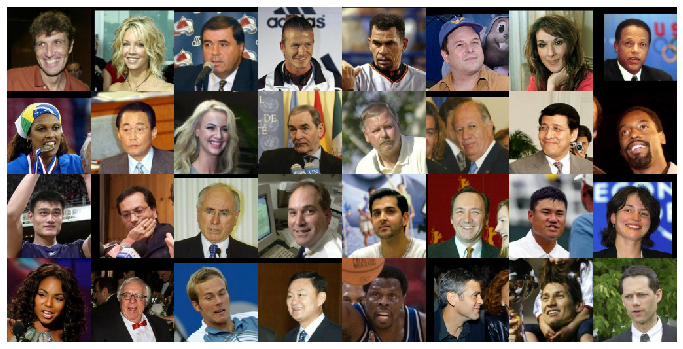

In [83]:
# Plotting one batch of images
it = iter(dataset)
batch = next(it)
plot_batch(batch)

In [0]:
def generate_images(generator, epoch):
    noise = tf.random.normal(shape=[32, codings_size])
    generated_images = generator(noise)
    # Undo the transformaton on the dataset
    generated_images = (generated_images+1)/2
    fig, ax = plot_batch(generated_images)
    ax.title(f'Result after epoch {epoch}')

In [0]:
# Code to train generator (exaclty the same as in simple_gan.ipynb)
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(n_epochs)):
        for X_batch in dataset:
            # train discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # train generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        # Inspect what the generator is producing
        if epoch % 5 == 0:
            generate_images(generator, epoch)

            

I have added an addtional layer compared to the network I used in simple_GANs.ipynb and scaled up the network so that it outputs images of size (128, 128)

In [0]:
codings_size = 100

n_layers = 3
input_shape = tuple(int(i/2**n_layers) for i in image_size)
n_dense_input = 128

cgan_generator = keras.models.Sequential([
    keras.layers.Dense(input_shape[0]*input_shape[1]*128, input_shape=[codings_size]),
    keras.layers.Reshape(input_shape + (n_dense_input,)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh"),
],name='generator')

cgan_discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=cgan_generator.output.shape[1:]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
],name='discriminator')

cgan = keras.models.Sequential([cgan_generator, cgan_discriminator])

cgan_discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
cgan_discriminator.trainable = False
cgan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [87]:
input_shape

(16, 16)

In [88]:
# Check the outputs of the gnerator and the input of the discriminator are the same
print(cgan_generator.output.shape)
print(cgan_discriminator.input.shape)

(None, 128, 128, 3)
(None, 128, 128, 3)








  0%|          | 0/10 [00:00<?, ?it/s]

TypeError: ignored

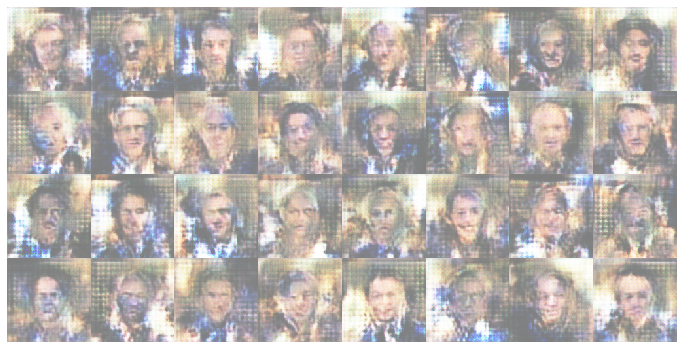

In [89]:
# Takes c. 13 minutes for 25 epochs on colab with gpu
train_gan(cgan, dataset, batch_size=32, codings_size=codings_size, n_epochs=10)

Checking the results of the network - the definitley look like faces but are not totally convincing

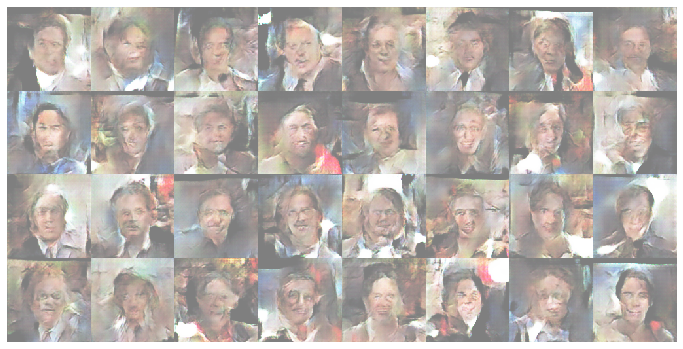

In [75]:
noise = tf.random.normal(shape=[32, codings_size])
generated_images = cgan_generator(noise)
# Undo the transformaton on the dataset
generated_images = (generated_images+1)/2
plot_batch(generated_images)